In [53]:
#!pip install -U opencv-python

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 46.4/46.4 MB 2.2 MB/s eta 0:00:0000:0100:01
  Attempting uninstall: opencv-python
    Found existing installation: opencv-python 4.5.5.62
    Uninstalling opencv-python-4.5.5.62:
      Successfully uninstalled opencv-python-4.5.5.62


In [2]:
import cv2
import numpy as np

from tensorflow.keras.models import load_model
from tensorflow.image import resize

from mtcnn.mtcnn import MTCNN

In [3]:
class_names = [ 'no_biting', 'biting']

model = load_model('../models/face_model')

2022-06-10 22:01:40.157324: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [4]:
model.summary()

Model: "sequential_12"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_12 (Rescaling)    (None, 128, 128, 1)       0         
                                                                 
 random_contrast_12 (RandomC  (None, 128, 128, 1)      0         
 ontrast)                                                        
                                                                 
 random_rotation_12 (RandomR  (None, 128, 128, 1)      0         
 otation)                                                        
                                                                 
 random_flip_12 (RandomFlip)  (None, 128, 128, 1)      0         
                                                                 
 conv2d_39 (Conv2D)          (None, 119, 119, 16)      1616      
                                                                 
 max_pooling2d_39 (MaxPoolin  (None, 59, 59, 16)     

In [22]:
def take_photo():
    cam = cv2.VideoCapture(0) # 0 -> index of camera
    s, image = cam.read()
    cam.release()
    return image

In [17]:
# extract a single face from a given photograph

def extract_face(img):
    # create the detector, using default weights
    detector = MTCNN()
    # detect faces in the image
    results = detector.detect_faces(img)
    
    if len(results) < 1:
        return None
    
    # extract the bounding box from the first face
    x1, y1, width, height = results[0]['box']
    x2, y2 = x1 + width, y1 + height
    # extract the face
    face = img[y1:y2, x1:x2]
    return face

def prepare_training_example(photo):
    img = cv2.cvtColor(photo, cv2.COLOR_BGR2RGB)
    face = extract_face(img)
    if face is None:
        return None
    face = resize(face, (128, 128))
    bw_face = cv2.cvtColor(face.numpy(), cv2.COLOR_BGR2GRAY)
    return np.expand_dims(bw_face, axis = [0, -1])

In [18]:
def predict_threshold(pred, threshold):
    if pred > threshold:
        return 1
    else:
        return 0

In [19]:
import matplotlib.pyplot as plt

def predict_report(X):
    pred_proba = model(X).numpy()[0][0]
    y_pred = predict_threshold(pred_proba, 0.5)
    plt.imshow(X[0], cmap = "Greys_r")
    plt.title(f'{class_names[y_pred]} : {round(pred_proba * 100, 2)}%')
    plt.show();

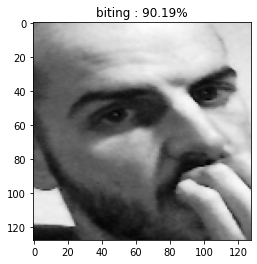

In [85]:
photo = take_photo()
my_photo = prepare_training_example(photo)
predict_report(my_photo)